# Network Analyzer Demo

This notebook demonstrates the Network Analyzer service capabilities:
- Detect overloaded nodes
- Recommend node placement locations
- Predict link quality over time


## 1. Setup and Imports


In [35]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

from models.database import db
from services.network_analyzer import NetworkAnalyzer

# Setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports successful")


✅ Imports successful


## 3.1. Visualize Network Overview


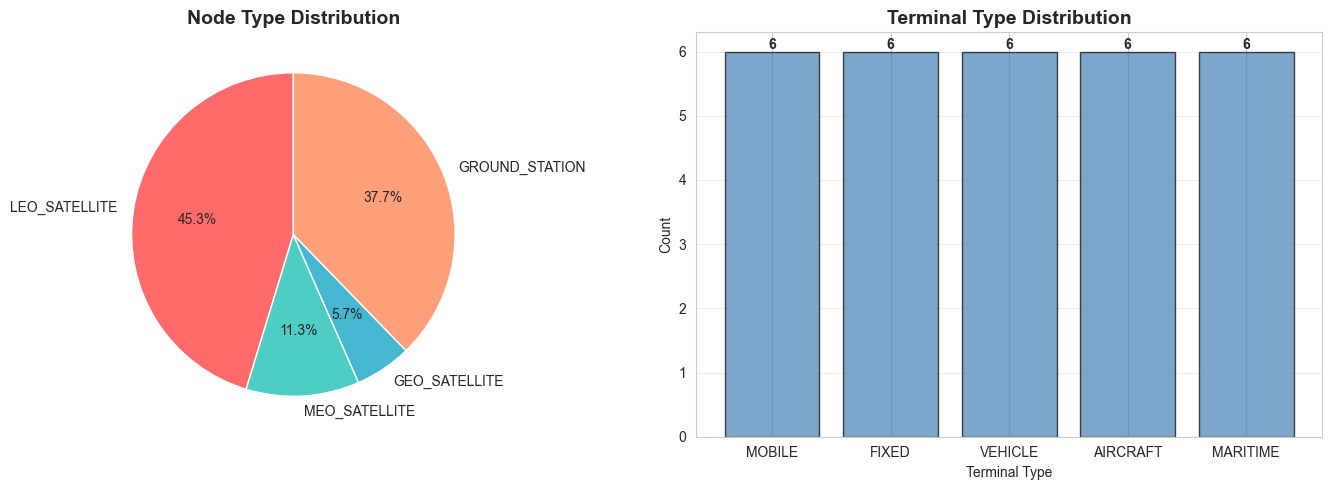

In [36]:
# Visualize network overview
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Node type distribution pie chart
node_type_counts = list(node_types.values())
node_type_labels = list(node_types.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

axes[0].pie(node_type_counts, labels=node_type_labels, autopct='%1.1f%%', 
           colors=colors[:len(node_type_counts)], startangle=90)
axes[0].set_title('Node Type Distribution', fontsize=14, fontweight='bold')

# Terminal type distribution
terminal_types = {}
for terminal in terminals:
    term_type = terminal.get('terminalType', 'UNKNOWN')
    terminal_types[term_type] = terminal_types.get(term_type, 0) + 1

if terminal_types:
    term_type_labels = list(terminal_types.keys())
    term_type_counts = list(terminal_types.values())
    axes[1].bar(term_type_labels, term_type_counts, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].set_title('Terminal Type Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Terminal Type')
    axes[1].set_ylabel('Count')
    axes[1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(term_type_counts):
        axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 2. Initialize Network Analyzer


## 3.2. Visualize Node Utilization Distribution


/var/folders/dg/5bzl6y_938d3mvk1b1n_6rwm0000gp/T/ipykernel_26100/2763823254.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True,


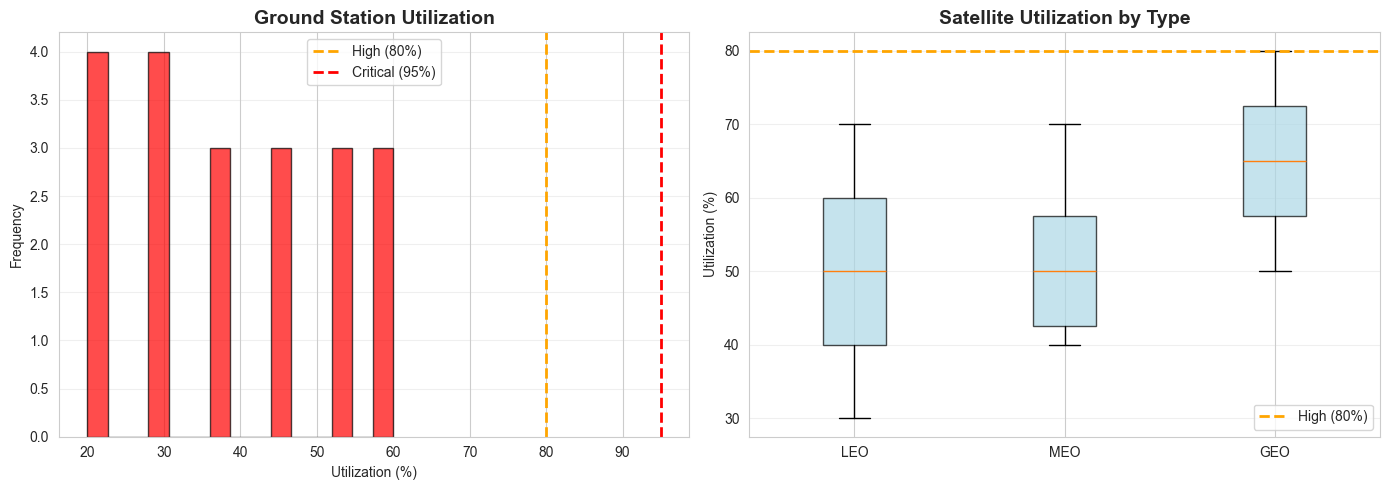

In [37]:
# Visualize node utilization by type
ground_stations = [n for n in nodes if n.get('nodeType') == 'GROUND_STATION']
satellites = [n for n in nodes if n.get('nodeType') in ['LEO_SATELLITE', 'MEO_SATELLITE', 'GEO_SATELLITE']]

if ground_stations or satellites:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Ground station utilization
    if ground_stations:
        gs_utilizations = [gs.get('resourceUtilization', 0) for gs in ground_stations]
        axes[0].hist(gs_utilizations, bins=15, color='red', alpha=0.7, edgecolor='black')
        axes[0].axvline(80, color='orange', linestyle='--', linewidth=2, label='High (80%)')
        axes[0].axvline(95, color='red', linestyle='--', linewidth=2, label='Critical (95%)')
        axes[0].set_title('Ground Station Utilization', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Utilization (%)')
        axes[0].set_ylabel('Frequency')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')
    
    # Satellite utilization by type
    if satellites:
        leo_utils = [s.get('resourceUtilization', 0) for s in satellites if s.get('nodeType') == 'LEO_SATELLITE']
        meo_utils = [s.get('resourceUtilization', 0) for s in satellites if s.get('nodeType') == 'MEO_SATELLITE']
        geo_utils = [s.get('resourceUtilization', 0) for s in satellites if s.get('nodeType') == 'GEO_SATELLITE']
        
        data_to_plot = []
        labels_to_plot = []
        if leo_utils:
            data_to_plot.append(leo_utils)
            labels_to_plot.append('LEO')
        if meo_utils:
            data_to_plot.append(meo_utils)
            labels_to_plot.append('MEO')
        if geo_utils:
            data_to_plot.append(geo_utils)
            labels_to_plot.append('GEO')
        
        if data_to_plot:
            axes[1].boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True,
                           boxprops=dict(facecolor='lightblue', alpha=0.7))
            axes[1].axhline(80, color='orange', linestyle='--', linewidth=2, label='High (80%)')
            axes[1].set_title('Satellite Utilization by Type', fontsize=14, fontweight='bold')
            axes[1].set_ylabel('Utilization (%)')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("No nodes to visualize")


In [38]:
# Connect to database
db.connect()
print("✅ Database connected")

# Initialize analyzer
analyzer = NetworkAnalyzer()
print("✅ Network Analyzer initialized")


✅ Database connected
✅ Network Analyzer initialized


## 3. Load Network Data


In [39]:
# Load nodes and terminals from database
nodes_collection = db.get_collection('nodes')
terminals_collection = db.get_collection('terminals')

nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}))
terminals = list(terminals_collection.find({}, {'_id': 0}))

print(f"📡 Loaded {len(nodes)} operational nodes")
print(f"📱 Loaded {len(terminals)} terminals")

# Node type distribution
node_types = {}
for node in nodes:
    node_type = node.get('nodeType', 'UNKNOWN')
    node_types[node_type] = node_types.get(node_type, 0) + 1

print("\nNode distribution:")
for node_type, count in node_types.items():
    print(f"   - {node_type}: {count}")


📡 Loaded 53 operational nodes
📱 Loaded 30 terminals

Node distribution:
   - LEO_SATELLITE: 24
   - MEO_SATELLITE: 6
   - GEO_SATELLITE: 3
   - GROUND_STATION: 20


## 4. Analyze Overloaded Nodes


In [40]:
# Analyze overloaded nodes (focus on ground stations)
overload_analysis = analyzer.analyze_overloaded_nodes(
    nodes=nodes,
    terminals=terminals,
    db=db,
    focus_ground_stations=True
)

print("=" * 60)
print("OVERLOADED NODES ANALYSIS")
print("=" * 60)
print(f"\nSummary:")
print(f"   - Total nodes analyzed: {overload_analysis['summary']['total_nodes_analyzed']}")
print(f"   - Overloaded nodes: {overload_analysis['summary']['overloaded_count']}")
print(f"   - At-risk nodes: {overload_analysis['summary']['at_risk_count']}")
print(f"   - Overload percentage: {overload_analysis['summary']['overload_percentage']:.1f}%")

if overload_analysis['overloaded_nodes']:
    print("\n⚠️  Overloaded Nodes:")
    for i, node in enumerate(overload_analysis['overloaded_nodes'][:5], 1):
        print(f"\n   {i}. {node['nodeName']} ({node['nodeType']})")
        print(f"      - Utilization: {node['utilization']:.1f}%")
        print(f"      - Packet Loss: {node['packetLoss']:.2f}%")
        print(f"      - Overload Score: {node['overloadScore']:.1f}%")
        if node.get('traffic_data', {}).get('total_packets', 0) > 0:
            print(f"      - Traffic: {node['traffic_data']['total_packets']} packets")
else:
    print("\n✅ No overloaded nodes found")


OVERLOADED NODES ANALYSIS

Summary:
   - Total nodes analyzed: 20
   - Overloaded nodes: 0
   - At-risk nodes: 0
   - Overload percentage: 0.0%

✅ No overloaded nodes found


## 4.1. Visualize Overload Analysis


In [41]:
# Create visualization for overload analysis
if overload_analysis['overloaded_nodes'] or overload_analysis['at_risk_nodes']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Overload status distribution
    overloaded_scores = [n['overloadScore'] for n in overload_analysis['overloaded_nodes']]
    at_risk_scores = [n['overloadScore'] for n in overload_analysis['at_risk_nodes']]
    
    axes[0].bar(['Overloaded', 'At Risk'], 
                [len(overloaded_scores), len(at_risk_scores)],
                color=['red', 'orange'], alpha=0.7)
    axes[0].set_title('Node Status Distribution', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Nodes')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Utilization distribution
    all_utilizations = [n['utilization'] for n in overload_analysis['overloaded_nodes'] + overload_analysis['at_risk_nodes']]
    if all_utilizations:
        axes[1].hist(all_utilizations, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
        axes[1].set_title('Utilization Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Utilization (%)')
        axes[1].set_ylabel('Frequency')
        axes[1].axvline(80, color='red', linestyle='--', linewidth=2, label='Threshold (80%)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No nodes to visualize - Network is healthy!")


✅ No nodes to visualize - Network is healthy!


In [42]:
# Display recommendations
if overload_analysis['recommendations']:
    print("\n" + "=" * 60)
    print("RECOMMENDATIONS")
    print("=" * 60)
    
    for i, rec in enumerate(overload_analysis['recommendations'], 1):
        print(f"\n{i}. {rec['message']}")
        print(f"   Priority: {rec['priority'].upper()}")
        print(f"   Suggestions:")
        for suggestion in rec['suggestions']:
            print(f"      - {suggestion}")


## 5.1. Visualize Placement Recommendations on Map


In [44]:
# Visualize recommendations on map
if placement_recommendations['recommendations']:
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Plot existing nodes
    node_type_colors = {
        'GROUND_STATION': 'red',
        'LEO_SATELLITE': 'blue',
        'MEO_SATELLITE': 'green',
        'GEO_SATELLITE': 'purple'
    }
    node_type_markers = {
        'GROUND_STATION': 's',
        'LEO_SATELLITE': 'o',
        'MEO_SATELLITE': '^',
        'GEO_SATELLITE': 'D'
    }
    node_type_labels = {
        'GROUND_STATION': 'Ground Station',
        'LEO_SATELLITE': 'LEO Satellite',
        'MEO_SATELLITE': 'MEO Satellite',
        'GEO_SATELLITE': 'GEO Satellite'
    }
    
    plotted_types = set()
    for node in nodes:
        pos = node.get('position')
        if pos:
            node_type = node.get('nodeType', '')
            color = node_type_colors.get(node_type, 'gray')
            marker = node_type_markers.get(node_type, 'o')
            label = node_type_labels.get(node_type, node_type) if node_type not in plotted_types else ''
            plotted_types.add(node_type)
            
            ax.scatter(pos.get('longitude', 0), pos.get('latitude', 0), 
                      c=color, marker=marker, s=100, alpha=0.6, label=label, edgecolors='black', linewidths=0.5)
    
    # Plot terminals
    for terminal in terminals:
        pos = terminal.get('position')
        if pos:
            ax.scatter(pos.get('longitude', 0), pos.get('latitude', 0), 
                      c='orange', marker='x', s=50, alpha=0.5, linewidths=2)
    
    # Plot recommendations
    for rec in placement_recommendations['recommendations']:
        ax.scatter(rec['longitude'], rec['latitude'], 
                  c='yellow', marker='*', s=800, edgecolors='black', linewidths=2,
                  label='Recommended Placement' if rec == placement_recommendations['recommendations'][0] else '',
                  zorder=10)
        ax.annotate(f"R{rec['rank']}", 
                   (rec['longitude'], rec['latitude']),
                   fontsize=12, fontweight='bold', ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title('Network Topology and Placement Recommendations', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No recommendations to visualize - Good coverage!")


✅ No recommendations to visualize - Good coverage!


## 5. Recommend Node Placement


## 6.1. Visualize Link Quality Prediction Over Time


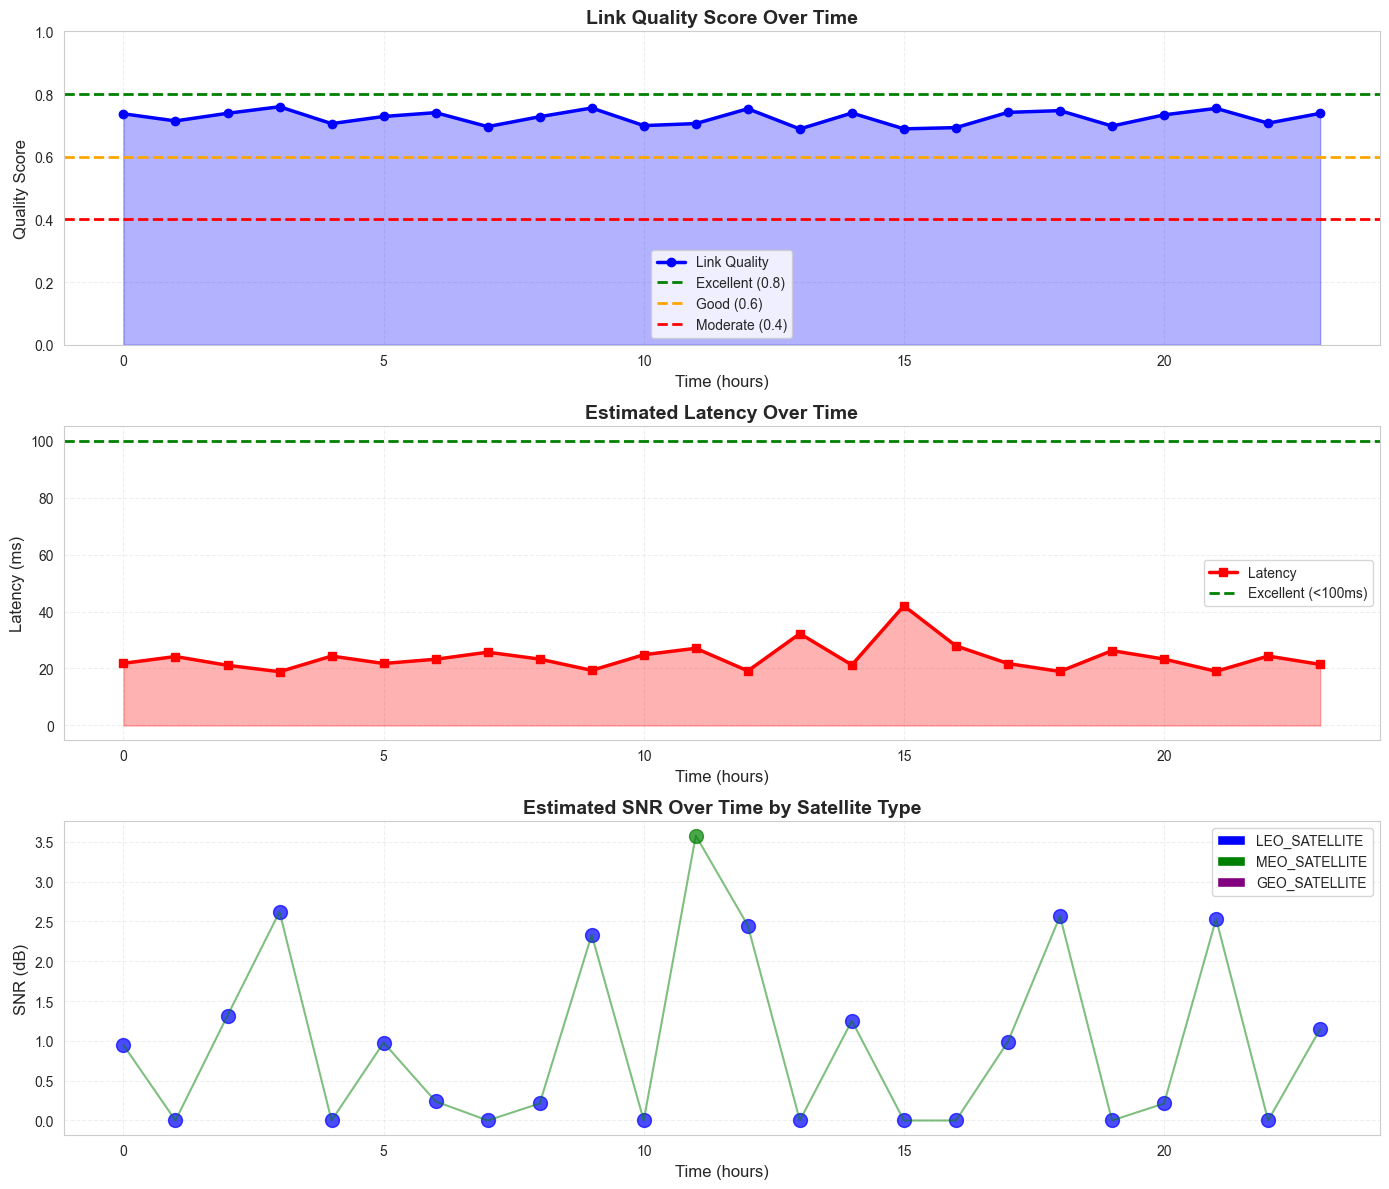


📊 Analysis Results:
   Best time: 3.0 hours (Quality: 0.759, Latency: 18.9ms)
   Worst time: 13.0 hours (Quality: 0.688, Latency: 32.2ms)
   Average quality: 0.725
   Average latency: 23.9ms


In [45]:
# Visualize link quality over time
if link_prediction and link_prediction.get('predictions'):
    predictions = link_prediction['predictions']
    
    times = [p['time_offset_hours'] for p in predictions]
    qualities = [p['best_link']['quality_score'] for p in predictions]
    latencies = [p['best_link']['estimated_latency_ms'] for p in predictions]
    snrs = [p['best_link']['estimated_snr_db'] for p in predictions]
    satellite_types = [p['best_link']['satellite_type'] for p in predictions]
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Quality score over time
    axes[0].plot(times, qualities, 'b-', linewidth=2.5, marker='o', markersize=6, label='Link Quality')
    axes[0].axhline(0.8, color='green', linestyle='--', linewidth=2, label='Excellent (0.8)')
    axes[0].axhline(0.6, color='orange', linestyle='--', linewidth=2, label='Good (0.6)')
    axes[0].axhline(0.4, color='red', linestyle='--', linewidth=2, label='Moderate (0.4)')
    axes[0].fill_between(times, qualities, alpha=0.3, color='blue')
    axes[0].set_title('Link Quality Score Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time (hours)', fontsize=12)
    axes[0].set_ylabel('Quality Score', fontsize=12)
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3, linestyle='--')
    axes[0].legend(loc='best', fontsize=10)
    
    # Latency over time
    axes[1].plot(times, latencies, 'r-', linewidth=2.5, marker='s', markersize=6, label='Latency')
    axes[1].axhline(100, color='green', linestyle='--', linewidth=2, label='Excellent (<100ms)')
    axes[1].fill_between(times, latencies, alpha=0.3, color='red')
    axes[1].set_title('Estimated Latency Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time (hours)', fontsize=12)
    axes[1].set_ylabel('Latency (ms)', fontsize=12)
    axes[1].grid(True, alpha=0.3, linestyle='--')
    axes[1].legend(loc='best', fontsize=10)
    
    # SNR over time with satellite type colors
    sat_type_colors = {
        'LEO_SATELLITE': 'blue',
        'MEO_SATELLITE': 'green',
        'GEO_SATELLITE': 'purple'
    }
    
    for i, (time, snr, sat_type) in enumerate(zip(times, snrs, satellite_types)):
        color = sat_type_colors.get(sat_type, 'gray')
        axes[2].scatter(time, snr, c=color, s=100, alpha=0.7, 
                       label=sat_type if i == 0 or sat_type != satellite_types[i-1] else '')
    
    axes[2].plot(times, snrs, 'g-', linewidth=1.5, alpha=0.5)
    axes[2].set_title('Estimated SNR Over Time by Satellite Type', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Time (hours)', fontsize=12)
    axes[2].set_ylabel('SNR (dB)', fontsize=12)
    axes[2].grid(True, alpha=0.3, linestyle='--')
    
    # Create custom legend for satellite types
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=label) 
                      for label, color in sat_type_colors.items()]
    axes[2].legend(handles=legend_elements, loc='best', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Show best and worst times
    if link_prediction.get('summary'):
        best_idx = qualities.index(max(qualities))
        worst_idx = qualities.index(min(qualities))
        
        print(f"\n📊 Analysis Results:")
        print(f"   Best time: {times[best_idx]:.1f} hours (Quality: {qualities[best_idx]:.3f}, Latency: {latencies[best_idx]:.1f}ms)")
        print(f"   Worst time: {times[worst_idx]:.1f} hours (Quality: {qualities[worst_idx]:.3f}, Latency: {latencies[worst_idx]:.1f}ms)")
        print(f"   Average quality: {np.mean(qualities):.3f}")
        print(f"   Average latency: {np.mean(latencies):.1f}ms")
else:
    print("⚠️  No predictions to visualize")


## 6.2. Satellite Type Usage Over Time


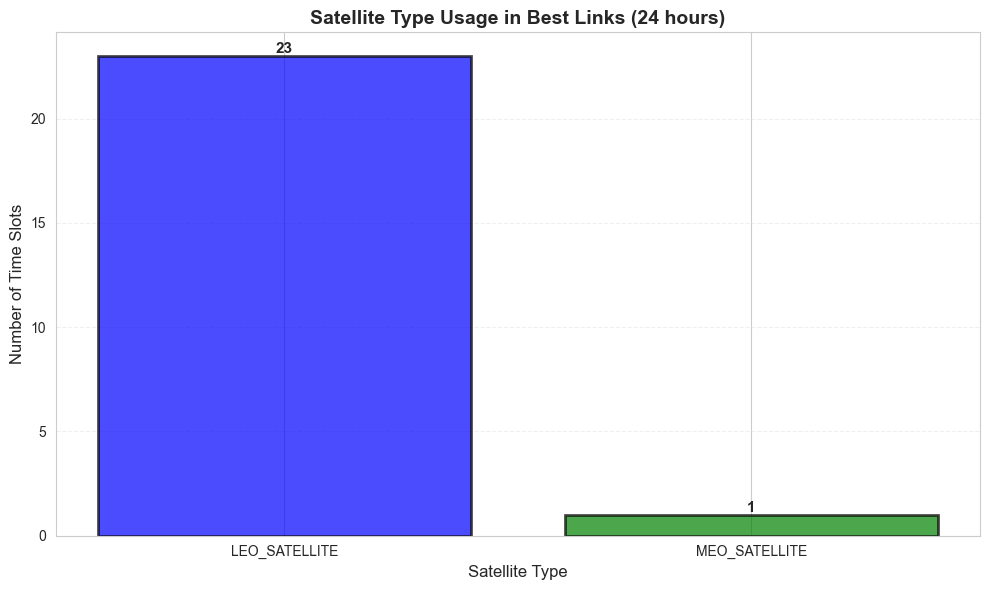


📡 Satellite Usage Summary:
   - LEO_SATELLITE: 23 time slots (95.8%)
   - MEO_SATELLITE: 1 time slots (4.2%)


In [46]:
# Analyze which satellite types are used over time
if link_prediction and link_prediction.get('predictions'):
    predictions = link_prediction['predictions']
    
    satellite_usage = {}
    for p in predictions:
        sat_type = p['best_link']['satellite_type']
        satellite_usage[sat_type] = satellite_usage.get(sat_type, 0) + 1
    
    if satellite_usage:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        colors = ['blue', 'green', 'purple']
        sat_types = list(satellite_usage.keys())
        counts = list(satellite_usage.values())
        
        bars = ax.bar(sat_types, counts, color=colors[:len(sat_types)], alpha=0.7, edgecolor='black', linewidth=2)
        ax.set_title('Satellite Type Usage in Best Links (24 hours)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Satellite Type', fontsize=12)
        ax.set_ylabel('Number of Time Slots', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📡 Satellite Usage Summary:")
        for sat_type, count in satellite_usage.items():
            percentage = (count / len(predictions)) * 100
            print(f"   - {sat_type}: {count} time slots ({percentage:.1f}%)")


In [47]:
# Get node placement recommendations
placement_recommendations = analyzer.recommend_node_placement(
    nodes=nodes,
    terminals=terminals,
    db=db,
    max_recommendations=5
)

print("=" * 60)
print("NODE PLACEMENT RECOMMENDATIONS")
print("=" * 60)

coverage = placement_recommendations['coverage_analysis']
print(f"\nCoverage Analysis:")
print(f"   - Total terminals: {coverage['total_terminals']}")
print(f"   - Covered terminals: {coverage['covered_terminals']}")
print(f"   - Coverage percentage: {coverage['coverage_percentage']:.1f}%")
print(f"   - Overloaded ground stations: {coverage['overloaded_ground_stations']}")

if placement_recommendations['recommendations']:
    print(f"\n📍 Top {len(placement_recommendations['recommendations'])} Placement Recommendations:")
    
    for rec in placement_recommendations['recommendations']:
        print(f"\n   Rank {rec['rank']}: {rec['recommended_type']}")
        print(f"      Location: ({rec['latitude']:.4f}, {rec['longitude']:.4f})")
        print(f"      Priority Score: {rec['priority_score']:.1f}")
        print(f"      Reason: {rec['reason']}")
        if rec.get('overloaded_gs_name'):
            print(f"      To offload: {rec['overloaded_gs_name']}")
        print(f"      Expected Benefits:")
        for benefit in rec['expected_benefits']:
            print(f"         - {benefit}")
else:
    print("\n✅ No placement recommendations (good coverage)")


NODE PLACEMENT RECOMMENDATIONS

Coverage Analysis:
   - Total terminals: 30
   - Covered terminals: 30
   - Coverage percentage: 100.0%
   - Overloaded ground stations: 0

✅ No placement recommendations (good coverage)


## 6. Predict Link Quality Over Time


In [48]:
# Select source and destination terminals for link prediction
link_prediction = None
if len(terminals) >= 2:
    source_terminal = terminals[0]
    dest_terminal = terminals[1] if len(terminals) > 1 else terminals[0]
    
    source_pos = source_terminal.get('position')
    dest_pos = dest_terminal.get('position')
    
    if source_pos and dest_pos:
        print(f"Predicting link quality from:")
        print(f"   Source: {source_terminal.get('terminalName', 'Terminal 1')} at ({source_pos.get('latitude'):.2f}, {source_pos.get('longitude'):.2f})")
        print(f"   Destination: {dest_terminal.get('terminalName', 'Terminal 2')} at ({dest_pos.get('latitude'):.2f}, {dest_pos.get('longitude'):.2f})")
        print("\n" + "=" * 60)
        
        # Predict for next 24 hours
        link_prediction = analyzer.predict_link_quality_over_time(
            source_pos=source_pos,
            dest_pos=dest_pos,
            nodes=nodes,
            time_horizon_hours=24,
            time_step_minutes=60
        )
        
        if link_prediction.get('summary'):
            summary = link_prediction['summary']
            print("LINK QUALITY PREDICTION SUMMARY")
            print("=" * 60)
            print(f"\nBest time: {summary.get('best_time', 'N/A')}")
            print(f"Best quality: {summary.get('best_quality', 0):.3f}")
            print(f"Average quality: {summary.get('average_quality', 0):.3f}")
            print(f"\nRecommendation: {summary.get('recommendation', 'N/A')}")
        else:
            print("⚠️  No predictions available")
    else:
        print("⚠️  Terminals missing position data")
else:
    print("⚠️  Need at least 2 terminals for link prediction")


Predicting link quality from:
   Source: MOBILE Terminal 1 (EASY) at (40.51, -74.21)
   Destination: FIXED Terminal 2 (EASY) at (33.95, -118.44)

LINK QUALITY PREDICTION SUMMARY

Best time: 2025-12-21T11:41:13.394454
Best quality: 0.758
Average quality: 0.725

Recommendation: Best link quality at 2025-12-21T11:41:13.394454 with LEO Satellite 8 (Plane 2)


## 7. Summary Report


In [49]:
# Generate summary report
print("=" * 60)
print("NETWORK ANALYZER SUMMARY REPORT")
print("=" * 60)
print(f"Generated at: {datetime.now().isoformat()}")
print(f"\nNetwork Status:")
print(f"   - Total nodes: {len(nodes)}")
print(f"   - Total terminals: {len(terminals)}")
print(f"   - Overloaded nodes: {overload_analysis['summary']['overloaded_count']}")
print(f"   - At-risk nodes: {overload_analysis['summary']['at_risk_count']}")
print(f"   - Coverage: {coverage['coverage_percentage']:.1f}%")
print(f"   - Placement recommendations: {len(placement_recommendations['recommendations'])}")

if link_prediction and link_prediction.get('summary'):
    print(f"\nLink Quality Prediction:")
    print(f"   - Average quality: {link_prediction['summary'].get('average_quality', 0):.3f}")
    print(f"   - Best quality: {link_prediction['summary'].get('best_quality', 0):.3f}")

print("\n" + "=" * 60)

# Close database connection
db.close()
print("✅ Database connection closed")


NETWORK ANALYZER SUMMARY REPORT
Generated at: 2025-12-20T17:41:15.907438

Network Status:
   - Total nodes: 53
   - Total terminals: 30
   - Overloaded nodes: 0
   - At-risk nodes: 0
   - Coverage: 100.0%
   - Placement recommendations: 0

Link Quality Prediction:
   - Average quality: 0.725
   - Best quality: 0.758

✅ Database connection closed
